## Pre Process


## Post Process


#### init function

In [2]:
import os, sys, random, json
from lib.library import delete_similar_image_in_subfolders, add_folder_name_to_files, rename_subfolders, copy_images_to_folder

[01/13/25 20:52:49] WARNING  Your inference package version 0.31.1 is out of date! Please upgrade to ]8;id=166040;file://e:\Research\Diffusion_Data_Tools\venv\Lib\site-packages\inference\core\__init__.py\__init__.py]8;;\:]8;id=688961;file://e:\Research\Diffusion_Data_Tools\venv\Lib\site-packages\inference\core\__init__.py#41\41]8;;\
                             version 0.33.0 of inference for the latest features and bug fixes by                  
                             running `pip install --upgrade inference`.                                            

In [3]:
import subprocess

def wd14_tagging_image(working_folder):
    print("wd14 tagging")
    command = [
        r"D:\Project\Code\Kohya\kohya_ss\venv\Scripts\accelerate.EXE", "launch",
        #r"D:\Project\Code\Diffusion_Data_Tools\myenv\Scripts\accelerate.EXE", "launch",
        r"D:\Project\Code\Diffusion_Data_Tools\lib\tag_images_by_wd14_tagger.py",
        "--batch_size", "1",
        "--caption_extension", ".txt",
        "--caption_separator", ",",
        "--character_threshold", "0.5",
        "--max_data_loader_n_workers", "2",
        "--onnx",
        "--recursive",
        "--remove_underscore",
        "--repo_id", "SmilingWolf/wd-v1-4-convnextv2-tagger-v2",
        working_folder,
    ]

    subprocess.run(command)

def blip_tagging_image(working_folder):
    print("blip tagging")
    
    command = [
        #r'D:\Project\Code\Kohya\kohya_ss\venv\Scripts\python.exe',
        #r'D:/Project/Code/Kohya/kohya_ss/sd-scripts/finetune/make_captions.py',
        r"E:\Research\Diffusion_Data_Tools\venv\Scripts\python.exe",
        r'E:\Research\Diffusion_Data_Tools\lib\make_captions.py',
        '--batch_size', '1',
        '--num_beams', '1',
        '--top_p', '0.9',
        '--max_length', '75',
        '--min_length', '5',
        '--beam_search',
        "--recursive",
        '--caption_extension', '.txt',
        working_folder,
        '--caption_weights', 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_large_caption.pth'
    ]
    
    subprocess.run(command)

In [4]:
def rename_txt_files_old(directory, suffix='_wd14'):
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith('.txt') and not file.endswith(f'{suffix}.txt'):
                old_file_path = os.path.join(root, file)
                new_file_path = os.path.join(root, f"{os.path.splitext(file)[0]}{suffix}.txt")
                if os.path.exists(new_file_path):
                    os.remove(new_file_path)
                os.rename(old_file_path, new_file_path)

def rename_txt_files(directory, suffix='_wd14'):
    for root, _, files in os.walk(directory):
        image_files = {os.path.splitext(file)[0] for file in files if file.endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))}
        for file in files:
            if file.endswith('.txt') and not file.endswith(f'{suffix}.txt'):
                txt_base_name = os.path.splitext(file)[0]
                if txt_base_name in image_files:
                    old_file_path = os.path.join(root, file)
                    new_file_path = os.path.join(root, f"{txt_base_name}{suffix}.txt")
                    if os.path.exists(new_file_path):
                        os.remove(new_file_path)
                    os.rename(old_file_path, new_file_path)

def create_json_files(directory, key = 'prompt_wd14'):
    for root, _, files in os.walk(directory):
        image_files = {os.path.splitext(file)[0] for file in files if file.endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))}
        for file in files:
            if file.endswith('.txt'):
                txt_base_name = os.path.splitext(file)[0]
                if txt_base_name in image_files:
                    txt_file_path = os.path.join(root, file)
                    json_file_path = os.path.join(root, f"{txt_base_name}_meta.json")
                    
                    # Read content from the text file
                    with open(txt_file_path, 'r') as txt_file:
                        content = txt_file.read().strip()
                    
                    # Create a dictionary with the content
                    new_data = {key: content}
                    
                    # Check if JSON file already exists
                    if os.path.exists(json_file_path):
                        # If it exists, load the existing data
                        with open(json_file_path, 'r') as json_file:
                            existing_data = json.load(json_file)
                        # Update the existing data with new data
                        existing_data.update(new_data)
                        data_to_write = existing_data
                    else:
                        data_to_write = new_data
                    
                    # Write the data to the JSON file
                    with open(json_file_path, 'w') as json_file:
                        json.dump(data_to_write, json_file, indent=4)
                    
                    # Optionally, remove the original text file
                    os.remove(txt_file_path)

def delete_flipped_images(directory, suffix='_wd14.txt'):
    # walk through the directory and its subfolders
    for root, dirs, files in os.walk(directory):
        flipped_images = [os.path.join(root, f) for f in files if f.endswith(suffix)]

        # delete the flipped images
        for flipped_image_path in flipped_images:
            os.remove(flipped_image_path)

In [5]:
def combine_and_cleanup_old(directory):
    for root, _, files in os.walk(directory):
        txt_files = [f for f in files if f.endswith('.txt') and not f.endswith('_wd14.txt')]
        for txt_file in txt_files:
            original_path = os.path.join(root, txt_file)
            wd14_path = original_path.replace('.txt', '_wd14.txt')

            if os.path.exists(wd14_path):
                with open(original_path, 'r', encoding='utf-8') as original_file:
                    original_content = original_file.read().replace('\n', ' ')

                with open(wd14_path, 'r', encoding='utf-8') as wd14_file:
                    wd14_content = wd14_file.read().replace('\n', ' ')

                combined_content = f"{original_content}, {wd14_content}"

                with open(original_path, 'w', encoding='utf-8') as combined_file:
                    combined_file.write(combined_content)

                os.remove(wd14_path)
                #print(f"Combined and deleted: {wd14_path}")



def combine_and_cleanup(directory):
    for root, _, files in os.walk(directory):
        txt_files = {f.replace('_wd14.txt', '').replace('_blip.txt', '') for f in files if f.endswith('_wd14.txt') or f.endswith('_blip.txt')}
        for base_name in txt_files:
            original_path = os.path.join(root, f"{base_name}.txt")
            wd14_path = os.path.join(root, f"{base_name}_wd14.txt")
            blip_path = os.path.join(root, f"{base_name}_blip.txt")

            contents = []

            if os.path.exists(blip_path):
                with open(blip_path, 'r', encoding='utf-8') as blip_file:
                    contents.append(blip_file.read().replace('\n', ' '))

            if os.path.exists(wd14_path):
                with open(wd14_path, 'r', encoding='utf-8') as wd14_file:
                    contents.append(wd14_file.read().replace('\n', ' '))

            combined_content = ', '.join(contents)
            
            if os.path.exists(original_path): os.remove(original_path)

            with open(original_path, 'w', encoding='utf-8') as combined_file:
                combined_file.write(combined_content)

            #if os.path.exists(wd14_path): os.remove(wd14_path)
            #if os.path.exists(blip_path): os.remove(blip_path)



In [6]:

def process_json_to_txt(directory):
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith('_meta.json'):
                json_file_path = os.path.join(root, file)
                txt_file_path = os.path.join(root, file.replace('_meta.json', '.txt'))
                
                # Read content from the JSON file
                with open(json_file_path, 'r') as json_file:
                    data = json.load(json_file)
                
                # Extract prompts
                prompt_wd14 = data.get('prompt_wd14', '')
                prompt_blip = data.get('prompt_blip', '')
                
                # Combine prompts
                combined_prompt = f"{prompt_blip}, {prompt_wd14}".strip()
                
                # Write the combined prompt to a text file
                with open(txt_file_path, 'w') as txt_file:
                    txt_file.write(combined_prompt)
                
                #print(f"Processed {file} to {os.path.basename(txt_file_path)}")

def process_json_to_txt_v2(directory):
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith('.json'):
                json_file_path = os.path.join(root, file)
                txt_file_path = os.path.join(root, file.replace('.json', '.txt'))
                
                # Read content from the JSON file
                with open(json_file_path, 'r') as json_file:
                    data = json.load(json_file)
                
                # Extract prompts
                prompt_cap = data.get('pg_cap', '')
                prompt_tag = data.get('pg_tag', '')
                
                # Combine prompts
                combined_prompt = f"{prompt_cap}, {prompt_tag}".strip()
                
                # Write the combined prompt to a text file
                with open(txt_file_path, 'w') as txt_file:
                    txt_file.write(combined_prompt)

#### main runner


In [8]:
working_folder = r'E:\Research\Diffusion_Data_Tools\data\tv\got\ss3'
#output_folder = r'E:\Research\symlink\CivitAI\princess live\0all\img III' 

delete_similar_image_in_subfolders(working_folder, similarity_threshold = 0.92)
#0.92 del 50-60%

Processing folder: batch_00
                                                                                    100% |█████████████████| 234/234 [37.7ms elapsed, 0s remaining, 6.2K samples/s]   
                                                                                100% |█████████████████| 234/234 [7.1s elapsed, 0s remaining, 32.7 samples/s] 
Initial image count: 234, Images retained: 141, Images deleted: 93
Processing folder: batch_01
                                                                                    100% |█████████████████| 190/190 [27.0ms elapsed, 0s remaining, 7.0K samples/s]   
                                                                                100% |█████████████████| 190/190 [4.1s elapsed, 0s remaining, 46.5 samples/s] 
Initial image count: 190, Images retained: 106, Images deleted: 84
Processing folder: batch_02
                                                                                    100% |█████████████████| 152/152 [26.2ms elaps

In [10]:
#wd14_tagging_image(working_folder)
#create_json_files(working_folder,'prompt_wd14')
blip_tagging_image(working_folder)
create_json_files(working_folder,'prompt_blip')
#process_json_to_txt(working_folder)
#add_folder_name_to_files(working_folder, mode='all', tag_dropping_rate = 0.5, drop_chance = 0.75)
#combine_and_cleanup(working_folder)
#add_folder_name_to_files(working_folder, mode='all', tag_dropping_rate = 0.5, drop_chance = 0.75)

blip tagging


In [11]:
working_folder = r'E:\Research\symlink\CivitAI\disney\realcartoon\draft'
output_folder = r'E:\Research\symlink\CivitAI\disney\realcartoon\draft-3' 

process_json_to_txt_v2(working_folder)
add_folder_name_to_files(working_folder, mode='all_score', tag_dropping_rate = 0.0, drop_chance = 0.5)
copy_images_to_folder(working_folder, output_folder)
rename_subfolders(output_folder, num_image_per_epoch=200)

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'E:\\Research\\symlink\\CivitAI\\disney\\realcartoon\\draft-3\\anna' -> 'E:\\Research\\symlink\\CivitAI\\disney\\realcartoon\\draft-3\\2_anna'

In [ ]:
#delete_flipped_images(working_folder,'_wd14.txt')
wd14_tagging_image(working_folder)
rename_txt_files(working_folder,'_wd14')
blip_tagging_image(working_folder)
rename_txt_files(working_folder,'_blip')
combine_and_cleanup(working_folder)
add_folder_name_to_files(working_folder, mode='all', tag_dropping_rate = 0.5, drop_chance = 0.75)
#rename_subfolders(working_folder)

wd14 tagging


In [ ]:
copy_images_to_folder(working_folder, output_folder)

In [ ]:
working_folder = r'D:\Project\Code\Diffusion_Data_Tools\data'
delete_similar_image_in_subfolders(working_folder)

Processing folder: aphrodite
                                                                                    100% |█████████████████| 150/150 [57.9ms elapsed, 0s remaining, 2.6K samples/s]   


d:\Project\Code\Diffusion_Data_Tools\myenv\lib\site-packages\torch\nn\functional.py:5504: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


                                                                                100% |█████████████████| 150/150 [6.3s elapsed, 0s remaining, 23.8 samples/s] 
Initial image count: 150, Images retained: 88, Images deleted: 62
Processing folder: apollo
                                                                                       100% |███████████████████| 26/26 [27.9ms elapsed, 0s remaining, 931.1 samples/s]     
                                                                                   100% |███████████████████| 26/26 [801.0ms elapsed, 0s remaining, 32.6 samples/s] 
Initial image count: 26, Images retained: 7, Images deleted: 19
Processing folder: artemis
                                                                                    100% |█████████████████| 129/129 [56.2ms elapsed, 0s remaining, 2.3K samples/s]   
                                                                                100% |█████████████████| 129/129 [5.1s elapsed, 0s remaining, 25.2 sample

In [ ]:
copy_images_to_folder(working_folder, output_folder)
rename_subfolders(output_folder)

In [ ]:
working_folder = r"D:\Project\CivitAI\Spiderman\draft\any"

delete_flipped_images(working_folder,'_wd14.txt')
wd14_tagging_image(working_folder)
rename_txt_files(working_folder)
blip_tagging_image(working_folder)
combine_and_cleanup(working_folder)
add_folder_name_to_files(working_folder, mode='all', tag_dropping_rate = 0.5, drop_chance = 0.75)
#rename_subfolders(working_folder)

wd14 tagging


blip tagging


## create prompt

In [6]:
import os, random

def get_text_files(directory):
    text_files = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(".txt"):
                text_files.append(os.path.join(root, file))
    return text_files

def create_output_file(file_counter, out_path):
    output_file = os.path.join(out_path, f'test_prompt_{file_counter}.txt')
    open(output_file, 'w').close()
    return output_file

score_ban = ["score_9,","score_8_up,","score_7_up,","score_6_up,","score_5_up,","score_4_up,",]
banned_phrases = ["from behind, ", "english text, ", "artist name, ",
                "twitter username, ", "nude, ", "penis, ", "breast, ",
                  "dark nipples, ", "huge nipples, ", "closed eyes, ",
                  "grayscale, ", "from side, ", "a close-up portrait of "]

def remove_phrases(line, phrases=banned_phrases):
    for phrase in score_ban:
        line = line.replace(phrase, "")
    for phrase in phrases:
        line = line.replace(phrase, "")
    return line


def process_file(txt_file, line_counter, file_counter, output_file, max_num_lines, suffix):
    with open(txt_file, 'r') as infile:
        for line in infile:
            line = remove_phrases(line)
            line_counter, file_counter, output_file = process_line(
                line, line_counter, file_counter, output_file, max_num_lines, suffix
            )
    return line_counter, file_counter, output_file

def process_subdir(sub_dir, line_counter, file_counter, output_file, max_num_lines, prompt_per_folder, suffix):
    text_files = get_text_files(sub_dir)
    if len(text_files) >= prompt_per_folder:
        selected_files = random.sample(text_files, prompt_per_folder)
        for txt_file in selected_files:
            line_counter, file_counter, output_file = process_file(
                txt_file, line_counter, file_counter, output_file, max_num_lines, suffix
            )
    return line_counter, file_counter, output_file

def process_directory(directory, max_num_lines, prompt_per_folder=2, out_path="", suffix=""):
    file_counter = 1
    line_counter = 0
    output_file = create_output_file(file_counter, out_path)

    for root, dirs, _ in os.walk(directory):
        for dir in dirs:
            sub_dir = os.path.join(root, dir)
            line_counter, file_counter, output_file = process_subdir(
                sub_dir, line_counter, 
                file_counter, output_file, 
                max_num_lines, prompt_per_folder, 
                suffix
            )

def process_line(line, line_counter, file_counter, output_file, max_num_lines, suffix):
    if line_counter >= max_num_lines:
        file_counter += 1
        line_counter = 0
        output_file = create_output_file(file_counter, os.path.dirname(output_file))
    with open(output_file, 'a') as outfile:
        prompt = (
            f'--prompt "score_9, score_8_up, score_7_up, '
            f'{line.strip()}, {suffix}" '
            #'--negative_prompt "score_9, score_8_up, score_7_up, score_6_up, score_5_up, score_4_up, '
            #'blurry, grayscale, text"\n'
            '--negative_prompt " score_6_up, score_5_up, score_4_up, '
            'blurry, grayscale, text, "\n'
        )
        outfile.write(prompt)
    return line_counter + 1, file_counter, output_file

In [7]:

working_folder = r'E:\Research\symlink\CivitAI\korean\squidgame\img'
out_path = r'E:\Research\symlink\CivitAI\korean\squidgame\sampling'
suffix  = " " #" volumetric lighting <lora:suicidesquad_pony_v1-0:0.95>"
max_num_lines = 12
prompt_per_folder = 2

os.makedirs(out_path, exist_ok=True)
process_directory(working_folder, max_num_lines, prompt_per_folder=prompt_per_folder, out_path = out_path, suffix=suffix)

## split combine

In [8]:
# init function
def split_file(filename, chunk_size=100*1024*1024):  # Default 100MB chunks
    """
    Splits a file into multiple chunks of specified size
    Args:
        filename: Name of file to split
        chunk_size: Size of each chunk in bytes
    """
    with open(filename, 'rb') as f:
        chunk_num = 0
        while True:
            chunk = f.read(chunk_size)
            if not chunk:
                break
            with open(f'{filename}.part{chunk_num:03d}', 'wb') as chunk_file:
                chunk_file.write(chunk)
            print(f'Created part {chunk_num}: {filename}.part{chunk_num:03d}')
            chunk_num += 1
    return chunk_num

# Windows-side script (combine_files.py)
def combine_files(base_filename, total_parts):
    """
    Combines split files back into original file
    Args:
        base_filename: Original filename without .partXXX
        total_parts: Total number of parts to combine
    """
    with open(f'{base_filename}', 'wb') as outfile:
        for i in range(total_parts):
            part_name = f'{base_filename}.part{i:03d}'
            print(f'Adding part {i}: {part_name}')
            with open(part_name, 'rb') as infile:
                outfile.write(infile.read())


In [ ]:
# split
filename = r""

In [9]:
#combine
filename = r"E:\Research\symlink\lora\princess_pony_v0-3-000050.safetensors"
num_part = 3
combine_files(filename, num_part)

Adding part 0: E:\Research\symlink\lora\princess_pony_v0-3-000050.safetensors.part000
Adding part 1: E:\Research\symlink\lora\princess_pony_v0-3-000050.safetensors.part001
Adding part 2: E:\Research\symlink\lora\princess_pony_v0-3-000050.safetensors.part002


## Other


In [1]:

from diffusers import AutoencoderKL

ckpt_path = r"E:\Research\symlink\model\PonyV6XL_4base.safetensors"
vae = AutoencoderKL.from_single_file(ckpt_path)
vae.eval()
vae.to('cuda')

e:\Research\Diffusion_Data_Tools\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


AutoencoderKL(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down_blocks): ModuleList(
      (0): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0-1): 2 x ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (nonlinearity): SiLU()
          )
        )
        (downsamplers): ModuleList(
          (0): Downsample2D(
            (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
          )
        )
      )
      (1): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0): ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (c

In [2]:
import numpy as np
import os, torch

file1 = r'E:\Research\symlink\CivitAI\disney\princess live\0support\anna_test\img\1_anna anastasia\1370913.npz'
#file2 = r'E:\Research\symlink\CivitAI\disney\princess live\0support\anna_test\img\black_anna\1370913.npz'
file2 = r'E:\Research\Diffusion_Data_Tools\data\test_out\1370913.npz'

data1 = np.load(file1)
data2 = np.load(file2)

In [3]:
latents1 = torch.from_numpy(data1['latents'][None]).to('cuda')
latents2 = torch.from_numpy(data2['latents'][None]).to('cuda')

In [4]:
from IPython.display import display
from PIL import Image

In [5]:
with torch.no_grad():
    image1 = vae.decode(latents1).sample
    image2 = vae.decode(latents2).sample

In [6]:
image1 = image1.cpu().numpy()
image2 = image2.cpu().numpy()

image1 = np.clip((image1 + 1) / 2, 0, 1)
image2 = np.clip((image2 + 1) / 2, 0, 1)

In [7]:
image1 = (image1[0] * 255).astype(np.uint8)
image2 = (image2[0] * 255).astype(np.uint8)
image1 = np.transpose(image1, (1, 2, 0))
image2 = np.transpose(image2, (1, 2, 0))

In [8]:

pil_image1 = Image.fromarray(image1)
pil_image2 = Image.fromarray(image2)

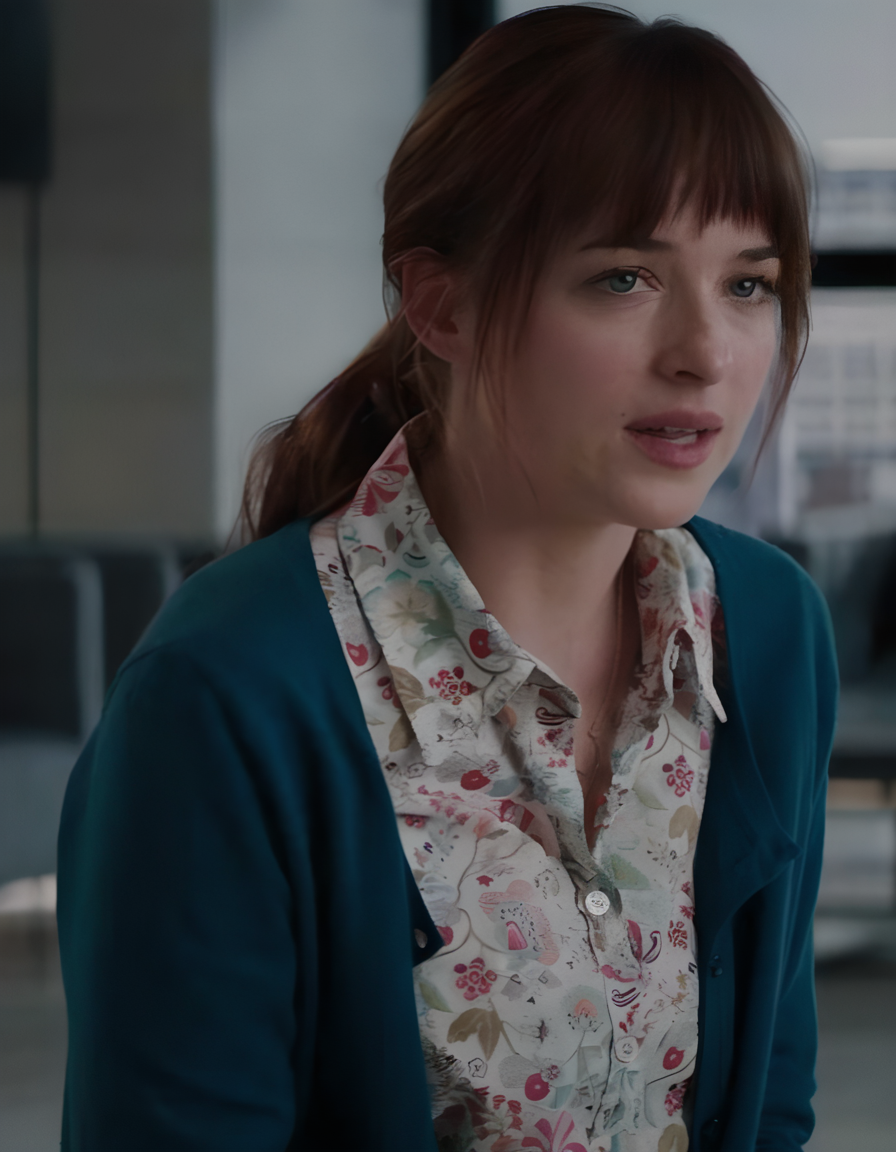

In [11]:
display(pil_image2)

In [3]:
print(data1['crop_ltrb'])
print(data2['crop_ltrb'])

[   0.            0.         1152.          895.77758471]
[   0.            0.         1152.          895.77758471]


In [4]:
print(data1['original_size'])
print(data2['original_size'])

[1151  895]
[1151  895]


In [5]:
data2.keys()

KeysView(NpzFile 'E:\\Research\\Diffusion_Data_Tools\\data\\test_out\\1370950.npz' with keys: latents, original_size, crop_ltrb)

(1, 4, 143, 111)

In [ ]:
import os

def delete_txt_files(folder_path):
    try:
        # Walk through the directory tree
        for root, dirs, files in os.walk(folder_path):
            for filename in files:
                # Check if the file has a .txt extension
                if filename.endswith(".txt"):
                    file_path = os.path.join(root, filename)
                    # Delete the file
                    os.remove(file_path)
                    #print(f"Deleted: {file_path}")
        
        print("All .txt files have been deleted from the folder and its subfolders.")
    except Exception as e:
        print(f"An error occurred: {e}")

In [ ]:
delete_txt_files(f"D:\Project\CivitAI\GameArt\hades\draft 2")

Deleted: D:\Project\CivitAI\GameArt\hades\draft 2\0other\download (1).txt
Deleted: D:\Project\CivitAI\GameArt\hades\draft 2\0other\download (1)_blip.txt
Deleted: D:\Project\CivitAI\GameArt\hades\draft 2\0other\download (1)_wd14.txt
Deleted: D:\Project\CivitAI\GameArt\hades\draft 2\0other\download (12).txt
Deleted: D:\Project\CivitAI\GameArt\hades\draft 2\0other\download (12)_blip.txt
Deleted: D:\Project\CivitAI\GameArt\hades\draft 2\0other\download (12)_wd14.txt
Deleted: D:\Project\CivitAI\GameArt\hades\draft 2\0other\download (14).txt
Deleted: D:\Project\CivitAI\GameArt\hades\draft 2\0other\download (14)_blip.txt
Deleted: D:\Project\CivitAI\GameArt\hades\draft 2\0other\download (14)_wd14.txt
Deleted: D:\Project\CivitAI\GameArt\hades\draft 2\0other\download (17).txt
Deleted: D:\Project\CivitAI\GameArt\hades\draft 2\0other\download (17)_blip.txt
Deleted: D:\Project\CivitAI\GameArt\hades\draft 2\0other\download (17)_wd14.txt
Deleted: D:\Project\CivitAI\GameArt\hades\draft 2\0other\downlo

In [ ]:
import os
import json

def update_json_files(folder):
    banned_list = ["chainsaw man",]
    
    for root, _, files in os.walk(folder):
        for file in files:
            if file.endswith(".json"):
                file_path = os.path.join(root, file)
                with open(file_path, 'r', encoding='utf-8') as f:
                    data = json.load(f)
                
                if 'prompt_wd14' in data:
                    prompts = data['prompt_wd14'].split(',')
                    updated_prompts = [prompt.strip() for prompt in prompts if not any(banned_word in prompt for banned_word in banned_list)]
                    data['prompt_wd14'] = ', '.join(updated_prompts)
                
                with open(file_path, 'w', encoding='utf-8') as f:
                    json.dump(data, f, ensure_ascii=False, indent=4)


In [ ]:
folder = r"D:\Project\CivitAI\anime\chainsaw man\draft"
update_json_files(folder)

In [ ]:
import os

def find_and_delete_duplicates(folder_path):
    # Dictionary to store file names and their paths
    file_dict = {}

    # Walk through the directory
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file in file_dict:
                # If the file is already in the dictionary, delete the duplicate
                duplicate_path = file_dict[file]
                #print(f"Deleting duplicate file: {duplicate_path}")
                os.remove(duplicate_path)
            else:
                # Otherwise, add the file to the dictionary
                file_dict[file] = os.path.join(root, file)


find_and_delete_duplicates(r"D:\Project\Code\Diffusion_Data_Tools\data\theboys")

FileNotFoundError: [WinError 2] The system cannot find the file specified: 'D:\\Project\\Code\\Diffusion_Data_Tools\\data\\theboys\\s1e2\\batch_6\\4497561.jpg'

In [ ]:
import os
from PIL import Image

def  flip_img(directory):
    # specify the prefixes
    prefixes = ['f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16']

    # walk through the directory and its subfolders
    for root, dirs, files in os.walk(directory):
        for prefix in prefixes:
            # find all png images in the current directory that start with the current prefix
            images = [os.path.join(root, f) for f in files if f.startswith(prefix) and f.endswith('.png')]

            for image_path in images:
                # open the image
                img = Image.open(image_path)

                # horizontally flip the image
                img = img.transpose(Image.FLIP_LEFT_RIGHT)

                # save the flipped image, overwriting the original one
                img.save(image_path)

In [ ]:
delete_flipped_images(r"D:\Project\CivitAI\Spiderman\draft\0other")

In [ ]:
flip_img(r"D:\Project\CivitAI\kimetsu no yaiba\draft")

In [ ]:
directory = r"D:\Project\CivitAI\GameArt\hades\training data2"
for root, _, files in os.walk(directory):
    print(files)

In [ ]:
import os
from PIL import Image

def delete_images(directory, target_number):
    # List all images and text files in the directory
    images = [f for f in os.listdir(directory) if f.endswith('.png')]
    texts = [f for f in os.listdir(directory) if f.endswith('.txt')]

    # If there are less or equal images than the target, do nothing
    if len(images) <= target_number:
        print("No need to delete images. Current number of images is less or equal to the target.")
        return

    # Dictionary to store image names and their minimum dimensions
    image_sizes = {}

    # Loop through the images and store their minimum dimensions
    for image in images:
        img_path = os.path.join(directory, image)
        with Image.open(img_path) as img:
            width, height = img.size
            min_size = min(width, height)
            image_sizes[image] = min_size

    # Sort the images by their minimum dimensions
    sorted_images = sorted(image_sizes.items(), key=lambda x: x[1])

    # Delete the smallest images until the target number is reached
    for i in range(len(sorted_images) - target_number):
        image_to_delete = sorted_images[i][0]
        img_path = os.path.join(directory, image_to_delete)
        os.remove(img_path)

    images = [f for f in os.listdir(directory) if f.endswith('.png')]
    # Delete text files that do not have a corresponding image
    for text in texts:
        img_name = f"{os.path.splitext(text)[0]}.png"
        if img_name not in images:
            txt_path = os.path.join(directory, text)
            os.remove(txt_path)

    print("Image resizing operation completed.")

def delete_txt_without_png(directory):
    # List all images and text files in the directory
    images = [f for f in os.listdir(directory) if f.endswith('.png')]
    texts = [f for f in os.listdir(directory) if f.endswith('.txt')]

    # Delete text files that do not have a corresponding image
    for text in texts:
        img_name = f"{os.path.splitext(text)[0]}.png"
        if img_name not in images:
            txt_path = os.path.join(directory, text)
            os.remove(txt_path)

In [ ]:
delete_txt_without_png(output_folder)

for subfolder in os.listdir(output_folder):
    full_path = os.path.join(output_folder, subfolder)
    if os.path.isdir(full_path):
        delete_txt_without_png(full_path)

In [ ]:
import os
import re

def get_original_folder_name(folder_name):
    original_name = re.sub(r'^\d+_', '', folder_name)
    return original_name if original_name else folder_name

def undo_rename_subfolders(root_folder):
    for dirpath, dirnames, _ in os.walk(root_folder, topdown=False):
        for dirname in dirnames:
            current_path = os.path.join(dirpath, dirname)
            original_name = get_original_folder_name(dirname)
            new_path = os.path.join(dirpath, original_name)
            os.rename(current_path, new_path)

# Example usage
root_folder = r'D:\Project\CivitAI\GameArt\hades\draft 2'
undo_rename_subfolders(root_folder)

In [ ]:
from lib.library import delete_similar_images

#delete_similar_images(working_folder,similarity_threshold = 0.93)

In [ ]:

working_folder = r"D:\Project\CivitAI\kimetsu no yaiba\draft\slayer\tanjiro kamado\2_bleading tanjiro"
delete_images(working_folder,100)

Image resizing operation completed.


In [ ]:
delete_txt(working_folder)

In [ ]:
import os

def rename_cropped_images(folder_path):
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.startswith("cropped_"):
                old_path = os.path.join(root, file)
                new_path = os.path.join(root, file[len("cropped_"):])
                os.rename(old_path, new_path)

# Replace 'cropped_' with the actual path to the folder
rename_cropped_images(r'D:\Project\CivitAI\Disney\princess comic\draft')


In [ ]:
# Select non-blur image
import os
import cv2
import numpy as np
from skimage.metrics import structural_similarity
from concurrent.futures import ThreadPoolExecutor
import argparse
from tqdm import tqdm

def variance_of_laplacian(image):
    return cv2.Laplacian(image, cv2.CV_64F).var()

def ssim_index(image):
    blurred = cv2.GaussianBlur(image, (25, 25), 0)
    return structural_similarity(image, blurred, channel_axis=2 if len(image.shape) > 2 else None)

def process_image(img_path):
    image = cv2.imread(img_path)
    if image is None:
        return None, None, None
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    vol = variance_of_laplacian(gray)
    ssim = ssim_index(image)
    return img_path, vol, ssim

def select_top_images(input_folder, output_folder, num_images=100):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    image_files = [f for f in os.listdir(input_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    results = []
    with ThreadPoolExecutor() as executor:
        futures = [executor.submit(process_image, os.path.join(input_folder, img)) for img in image_files]
        for future in tqdm(futures, total=len(image_files), desc="Processing images"):
            result = future.result()
            if result[0] is not None:
                results.append(result)

    # Normalize scores
    vol_scores = np.array([r[1] for r in results])
    ssim_scores = np.array([r[2] for r in results])
    vol_norm = (vol_scores - vol_scores.min()) / (vol_scores.max() - vol_scores.min())
    ssim_norm = (ssim_scores - ssim_scores.min()) / (ssim_scores.max() - ssim_scores.min())

    # Calculate combined score (higher is better for both metrics)
    combined_scores = vol_norm + (1 - ssim_norm)  # Invert SSIM because lower is actually better

    # Sort and select top images
    top_indices = combined_scores.argsort()[-num_images:][::-1]
    
    # Copy top images to output folder
    for i, idx in enumerate(top_indices):
        src_path = results[idx][0]
        #dst_path = os.path.join(output_folder, f"top_{i+1:03d}_{os.path.basename(src_path)}")
        dst_path = os.path.join(output_folder, os.path.basename(src_path))
        cv2.imwrite(dst_path, cv2.imread(src_path))

    print(f"Selected and saved {num_images} images to {output_folder}")


In [ ]:
#caitlyn, mel
input_folder = r'D:\Project\CivitAI\TV\theboys\draft\thebig3\hughie campbell'
output_folder = r'D:\Project\CivitAI\TV\theboys\draft\thebig3\hughie campbell out'
select_top_images(input_folder, output_folder, 200)

Processing images: 100%|██████████| 310/310 [01:24<00:00,  3.65it/s]


Selected and saved 200 images to D:\Project\CivitAI\TV\theboys\draft\thebig3\hughie campbell out
